## Plate_4042 Red Spectra Analysis

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

In [2]:
import bossdata
print(bossdata.__version__)

0.3.1


In [51]:
import bossdata.path
import bossdata.remote
import bossdata.meta 
import bossdata.spec as spec
import bossdata.plate as plate

In [378]:
import astropy.io.fits as fits
from astropy.table import Table
from astropy import stats

In [5]:
import fitsio
from fitsio import FITS, FITSHDR

In [6]:
from operator import and_

In [7]:
import os
workdir = os.environ['SCRATCH']
os.environ["BOSS_DATA_URL"] = 'http://dr12.sdss3.org'
os.environ["BOSS_LOCAL_ROOT"] = os.path.join(workdir,'sdss')
os.environ["BOSS_SAS_PATH"] = '/sas/dr12/boss'
os.environ["BOSS_REDUX_VERSION"]='v5_7_0'

In [8]:
os.chdir(workdir)
os.getcwd()

'/scratch/kunjias'

In [194]:
finder = bossdata.path.Finder()
mirror = bossdata.remote.Manager()

#### Simulated fibers by spectrograph

Whole range of fibers from 1-500 and 501-1000. Analysis proceeds with fibers by object type.

In [218]:
all_fibers1 = np.arange(1,501,1)

In [196]:
all_fibers2 = np.arange(501,1001,1)

### PlateFile

The PlugMap which contains Object type information is accessed through the Plate File to obtain the sky fiber ID data, and the fiber ID for other object types.

In [10]:
plate_file_path = finder.get_plate_spec_path(plate=4042,mjd=55626)

In [11]:
plate_file_path

'/sas/dr12/boss/spectro/redux/v5_7_0/4042/spPlate-4042-55626.fits'

In [12]:
plate_file = mirror.get(plate_file_path, progress_min_size=2,auto_download=True, local_paths=None)

In [13]:
plate_file

'/scratch/kunjias/sdss/sas/dr12/boss/spectro/redux/v5_7_0/4042/spPlate-4042-55626.fits'

In [14]:
plate = plate.PlateFile(plate_file)

In [15]:
type(plate)

bossdata.plate.PlateFile

In [16]:
plug_map = plate.plug_map

In [17]:
type(plug_map)

astropy.table.table.Table

In [18]:
plug_map.columns

<TableColumns names=('OBJID','HOLETYPE','RA','DEC','MAG','STARL','EXPL','DEVAUCL','OBJTYPE','XFOCAL','YFOCAL','SPECTROGRAPHID','FIBERID','THROUGHPUT','PRIMTARGET','SECTARGET','OFFSETID','SCI_EXPTIME','SOURCETYPE','LAMBDA_EFF','ZOFFSET','BLUEFIBER','BOSS_TARGET1','BOSS_TARGET2','ANCILLARY_TARGET1','ANCILLARY_TARGET2','RUN','RERUN','CAMCOL','FIELD','ID','CALIBFLUX','CALIBFLUX_IVAR','CALIB_STATUS','SFD_EBV')>

In [190]:
#plug_map

In [20]:
plug_map_by_OBJTYPE = plug_map.group_by('OBJTYPE')

In [191]:
#print (plug_map_by_OBJTYPE)

In [22]:
print(plug_map_by_OBJTYPE.groups.keys)

    OBJTYPE     
----------------
GALAXY          
NA              
QSO             
SKY             
SPECTROPHOTO_STD


In [23]:
print(plug_map_by_OBJTYPE.groups.indices)

[   0  660  687  883  980 1000]


In [24]:
print(plug_map.group_by(['OBJTYPE','FIBERID']).groups.keys)

    OBJTYPE      FIBERID
---------------- -------
GALAXY                 1
GALAXY                 3
GALAXY                 5
GALAXY                 7
GALAXY                 9
GALAXY                11
GALAXY                13
GALAXY                17
GALAXY                19
GALAXY                21
             ...     ...
SPECTROPHOTO_STD     506
SPECTROPHOTO_STD     548
SPECTROPHOTO_STD     590
SPECTROPHOTO_STD     650
SPECTROPHOTO_STD     744
SPECTROPHOTO_STD     748
SPECTROPHOTO_STD     804
SPECTROPHOTO_STD     826
SPECTROPHOTO_STD     906
SPECTROPHOTO_STD     908
SPECTROPHOTO_STD     946
Length = 1000 rows


#### Sky fibers

In [205]:
sky = plug_map_by_OBJTYPE.groups[3]

In [192]:
#print(sky)

In [206]:
type(sky['FIBERID'])

astropy.table.column.Column

In [193]:
#sky['FIBERID']

In [207]:
sky_fibers = np.array(sky['FIBERID'])

In [247]:
#sky_fibers

In [209]:
len(sky_fibers)

97

There are 97 sky fibers in among the 1000 fibers in plate_4042, which is around the average 10% sky fiber ratio in BOSS Survey design.

#### Sky Fibers seperated by Spectrograph

In [211]:
def spec1_fiber(fibers):
    fibers1 = []
    for i in range(0,len(fibers)):
        if fibers[i] < 501:
            fibers1.append(fibers[i])
    return fibers1

In [212]:
def spec2_fiber(fibers):
    fibers2 = []
    for i in range(0,len(fibers)):
        if fibers[i] >= 501:
            fibers2.append(fibers[i])
    return fibers2

In [213]:
sky_fibers1 = spec1_fiber(sky_fibers)

In [198]:
#sky_fibers1

In [241]:
len(sky_fibers1)

47

In [38]:
sky_fibers2 = spec2_fiber(sky_fibers)

In [39]:
#sky_fibers2

In [40]:
len(sky_fibers2)

50

#### Non-SKY Fibers

In [246]:
non_sky_fibers1 = list(filter(lambda x: x not in sky_fibers1, all_fibers1))

In [242]:
len(non_sky_fibers1)

453

In [243]:
non_sky_fibers2 = list(filter(lambda x: x not in sky_fibers2, all_fibers2))

In [245]:
len(non_sky_fibers2)

450

## Plate 4042 plan file

Path to plan file and download to workspace.

In [43]:
combined_plan_path = finder.get_plate_plan_path(plate=4042,mjd=55626, combined=True)

In [44]:
combined_plan_path

'/sas/dr12/boss/spectro/redux/v5_7_0/4042/spPlancomb-4042-55626.par'

In [45]:
combined_plan_file = mirror.get(combined_plan_path, progress_min_size=2,auto_download=True, local_paths=None)

In [49]:
combined_plan_file

'/scratch/kunjias/sdss/sas/dr12/boss/spectro/redux/v5_7_0/4042/spPlancomb-4042-55626.par'

The plan file for configuring BOSS pipeline to combined exposures of plate 4042.

In [52]:
combined_plan = plate.Plan(combined_plan_file)

In [53]:
combined_plan

Get the spectrograph index.

In [54]:
combined_plan.get_spectrograph_index(1)

1

In [55]:
combined_plan.get_spectrograph_index(500)

1

In [56]:
combined_plan.get_spectrograph_index(501)

2

In [57]:
combined_plan.get_spectrograph_index(1000)

2

### Exposure[0], Spectrograph 1, Fiber 1-500

Locate and download the file of a single science exposure for spectrogtaph 1. The exposure file to return is set to 'spCFrame'.

In [58]:
exp0_spec1_path = combined_plan.get_exposure_name(sequence_number=0,band='red',fiber=1,ftype='spCFrame')

In [59]:
exp0_spec1_path

'/sas/dr12/boss/spectro/redux/v5_7_0/4042/spCFrame-r1-00127588.fits'

In [60]:
exp0_spec1_file = mirror.get(exp0_spec1_path)

In [61]:
exp0_spec1_file

'/scratch/kunjias/sdss/sas/dr12/boss/spectro/redux/v5_7_0/4042/spCFrame-r1-00127588.fits'

#### Frame file of exposure[0] of spectrograph 1

Frame file containing single exposure 0 of spectrograph 1 (half plate).

In [62]:
expo0_spec1_frame = plate.FrameFile(exp0_spec1_file, index=1, calibrated = True)

In [63]:
# expo0_spec1_frame
print('plate_number:',expo0_spec1_frame.plate,
'camera:',expo0_spec1_frame.camera,
'exposure_id:',expo0_spec1_frame.exposure_id)
# expo0_spec1_frame.header

plate_number: 4042 camera: r1 exposure_id: 127588


#### Concern with wavelength shifts?

In [64]:
fiber2 = expo0_spec1_frame.get_valid_data(fibers = [2],pixel_quality_mask=None, include_wdisp=False, include_sky=True, use_ivar=True, use_loglam=False)

In [65]:
fiber3 = expo0_spec1_frame.get_valid_data(fibers = [3],pixel_quality_mask=None, include_wdisp=False, include_sky=True, use_ivar=True, use_loglam=False)

In [66]:
fiber2.shape

(1, 4128)

In [67]:
fiber3.shape

(1, 4128)

In [68]:
wavelength_2 = fiber2['wavelength'].data

In [69]:
wavelength_3 = fiber3['wavelength'].data

In [70]:
np.mean((wavelength_3 - wavelength_2)/wavelength_2)

-3.5473622e-05

In [71]:
np.mean((wavelength_3 - wavelength_2)/wavelength_3)

-3.547517e-05

The BOSS spectroscopic data is taken under resolution of 1500 at 3800 Å, 2500 at 9000 Å.

In [72]:
1/2500

0.0004

In [73]:
1/1500

0.0006666666666666666

The percentage change in wavelength data between fiber2 and fiber 3 is less than 1%, and inverse of BOSS's resolution is larger than the percentage change in wavelength difference between fibers. Thus, the wavelength shift is negligible. (These two fibers are taken as examples.)

#### Get valid data for the 47 sky fibers in Spectrograph 1.

In [74]:
spec1_sky = expo0_spec1_frame.get_valid_data(fibers = sky_fibers1,pixel_quality_mask=None, include_wdisp=False, include_sky=True, use_ivar=True, use_loglam=False)

In [75]:
#spec1_sky

In [76]:
spec1_sky.shape

(47, 4128)

In [220]:
type(spec1_sky)

numpy.ma.core.MaskedArray

Access the wavelength, flux, sky, and ivar fields by creating new masked arrays.

#### Wavelength

In [83]:
wavelength_spec1 = spec1_sky['wavelength']

In [84]:
wavelength_spec1.shape

(47, 4128)

Total number of data points if all are valid.

In [85]:
47 * 4128

194016

Count the number of non-masked elements along rows (fibers).

In [86]:
wavelength_spec1.count(axis=1)

array([4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128,
       4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128,
       4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128,
       4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128,
       4128, 4128, 4128])

Total number of valid elements in the flux  masked array.

In [87]:
wavelength_spec1.count(axis=1).sum()

194016

#### Flux

In [88]:
flux_spec1 = spec1_sky['flux']

In [89]:
flux_spec1.shape

(47, 4128)

In [90]:
flux_spec1.count(axis=1)

array([2224, 2243, 2203, 2159, 2220, 2248, 2186, 2195, 2172, 2184, 2160,
       2211, 2160, 2189, 2190, 2187, 2189, 2213, 2195, 2201, 2159, 2181,
       2199, 2177, 2182, 2152, 2161, 2180, 2183, 2150, 2207, 2169, 2175,
       2181, 2180, 2129, 2170, 2162, 2175, 2182, 2178, 2175, 2200, 2182,
       2237, 2189, 2212])

In [91]:
flux_spec1.count(axis=1).sum()

102756

#### Sky

In [92]:
sky_spec1 = spec1_sky['sky']

In [93]:
sky_spec1.count(axis=1)

array([2224, 2243, 2203, 2159, 2220, 2248, 2186, 2195, 2172, 2184, 2160,
       2211, 2160, 2189, 2190, 2187, 2189, 2213, 2195, 2201, 2159, 2181,
       2199, 2177, 2182, 2152, 2161, 2180, 2183, 2150, 2207, 2169, 2175,
       2181, 2180, 2129, 2170, 2162, 2175, 2182, 2178, 2175, 2200, 2182,
       2237, 2189, 2212])

In [94]:
sky_spec1.count(axis=1).sum()

102756

#### Sky + Flux

In [95]:
total_flux_spec1 = np.ma.array(flux_spec1.data+sky_spec1.data, mask=list(map(and_,flux_spec1.mask, sky_spec1.mask)))

In [96]:
# total_flux_a = flux_a + sky_a
# Is it a correct operation to obtain the sum of two masked numpy array?

In [97]:
total_flux_spec1.shape

(47, 4128)

In [98]:
total_flux_spec1.count(axis=1)

array([2224, 2243, 2203, 2159, 2220, 2248, 2186, 2195, 2172, 2184, 2160,
       2211, 2160, 2189, 2190, 2187, 2189, 2213, 2195, 2201, 2159, 2181,
       2199, 2177, 2182, 2152, 2161, 2180, 2183, 2150, 2207, 2169, 2175,
       2181, 2180, 2129, 2170, 2162, 2175, 2182, 2178, 2175, 2200, 2182,
       2237, 2189, 2212])

Check the total number of valid data in total_flux.

In [99]:
len(total_flux_spec1.compressed())

102756

#### Inverse Variance

Inverse Variance is used as weights to computed the weighted average of total flux for sky fibers.

In [100]:
ivar_spec1 = spec1_sky['ivar']

In [101]:
type(ivar_spec1)

numpy.ma.core.MaskedArray

In [102]:
ivar_spec1.shape

(47, 4128)

Check number of valid data in the inverse variance masked array.

In [103]:
ivar_spec1.count(axis=1).sum()

102756

Fill in the invalid inverse variance data with value 0.

In [104]:
weights_by_ivar = ma.filled(ivar_spec1, fill_value=0)

In [105]:
type(weights_by_ivar)

numpy.ndarray

In [106]:
weights_by_ivar.shape

(47, 4128)

A plot for the total flux among the 47 sky fibers in spectrograph 1.

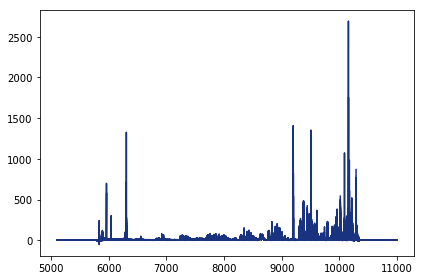

In [170]:
x = wavelength_spec1.data
y = total_flux_spec1.data
plt.plot(x,y,c =[0.1,0.2,0.5])
plt.tight_layout()
plt.show()

##### Simple Average
Average of total_flux among 47 sky fibers with no weights.

In [107]:
simple_average = ma.average(total_flux_spec1, axis=0, returned=False)

In [108]:
type(simple_average)

numpy.ma.core.MaskedArray

In [109]:
simple_average_flux1 = simple_average.data

Wavelegnth from the first sky fiber (fiber no.14) is taken as the standard wavelength scale to plot the total_flux here.

In [111]:
wavelength_fiber14 = wavelength_spec1[0]

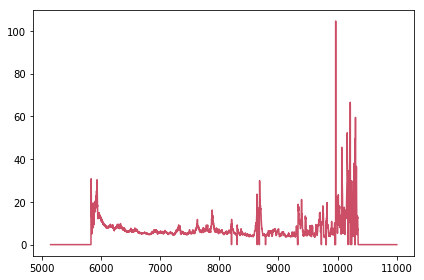

In [112]:
x = wavelength_fiber14
y = simple_average_flux1
plt.plot(x,y,c =[0.8,0.3,0.4])
plt.tight_layout()
plt.show()

#### Weighted Average
Average of total_flux of 47 sky fibers in spectrograph 1 weighted by inverse variance.

In [336]:
weighted_average_spec1 = ma.average(total_flux_spec1,axis=0, weights = weights_by_ivar, returned= False)

In [267]:
type(weighted_average_spec1)

numpy.ma.core.MaskedArray

In [268]:
average_sky_flux1 = weighted_average_spec1.data

Wavelegnth from the first sky fiber (fiber no.14) is taken as the standard wavelength scale to plot the total_flux here.

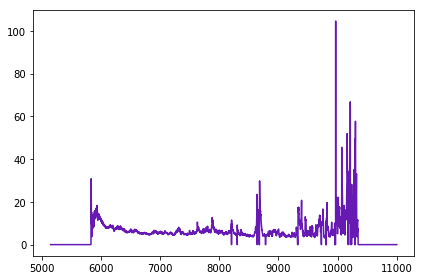

In [434]:
x = wavelength_fiber14
y = average_sky_flux1
plt.plot(x,y,c =[0.4,0.1,0.7])
plt.tight_layout()
plt.show()

### Testing of weighted average

In [180]:
total_flux_spec1.shape

(47, 4128)

In [181]:
average_sky_flux1.shape

(4128,)

In [352]:
type(weighted_average_spec1)

numpy.ma.core.MaskedArray

In [355]:
weighted_average_spec1.shape

(4128,)

In [353]:
weighted_average_spec1.count()

3110

In [347]:
type(average_sky_flux1)

numpy.ndarray

In [348]:
len(average_sky_flux1)

4128

### Non-SKY Fibers

The weighted average of total_flux from sky fibers are subtracted from the total_flux from non-sky fibers. The difference is compared to the flux values from non-sky fibers to check the weighted average's accuracy.

#### Get valid data for the 453 non-sky fibers in Spectrograph 1.

In [248]:
spec1_non_sky = expo0_spec1_frame.get_valid_data(fibers = non_sky_fibers1, pixel_quality_mask=None, include_wdisp=False, include_sky=True, use_ivar=True, use_loglam=False)

In [249]:
spec1_non_sky.shape

(453, 4128)

In [250]:
type(spec1_non_sky)

numpy.ma.core.MaskedArray

#### Non-SKY Flux

In [251]:
flux_non_sky_spec1 = spec1_non_sky['flux']

In [252]:
flux_non_sky_spec1.shape

(453, 4128)

In [254]:
#flux_non_sky_spec1.count(axis=1)

In [255]:
flux_non_sky_spec1.count(axis=1).sum()

1000417

In [256]:
453 * 4128

1869984

#### Non-SKY Sky

In [257]:
sky_non_sky_spec1 = spec1_non_sky['sky']

In [258]:
sky_non_sky_spec1.shape

(453, 4128)

In [368]:
len(sky_non_sky_spec1.count(axis=1))

453

#### Non-SKY Sky + Flux

In [260]:
total_flux_non_sky_spec1 = np.ma.array(flux_non_sky_spec1.data + sky_non_sky_spec1.data, mask = list(map(and_, flux_non_sky_spec1.mask, sky_non_sky_spec1.mask)))

In [261]:
total_flux_non_sky_spec1.shape

(453, 4128)

In [263]:
total_flux_non_sky_spec1.count(axis=1).sum()

1000417

#### Weighted average sky subtracted from Non-SKY Total Flux

In [387]:
weighted_average_spec1

masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=1e+20,
            dtype=float32)

In [276]:
weighted_average_spec1.shape

(4128,)

In [277]:
type(weighted_average_spec1.data)

numpy.ndarray

In [278]:
weighted_average_spec1.shape

(4128,)

In [292]:
type(average_sky_flux1)

numpy.ndarray

In [289]:
average_sky_flux1.shape

(4128,)

In [357]:
repeated453_average_sky_flux1 = np.tile(average_sky_flux1, (453,1))

In [386]:
repeated453_average_sky_flux1.shape

(453, 4128)

#### Total Flux of SKY Fibers subtracted by the average sky signal
Subtract Average Total Flux of Sky Fibers from Total Flux of each SKY Fibers

In [419]:
repeated47_average_sky_flux1 = np.tile(average_sky_flux1, (47,1))

In [420]:
repeated47_average_sky_flux1.shape

(47, 4128)

In [421]:
total_flux_residuals_sky_fiber = np.ma.array(total_flux_spec1.data - repeated47_average_sky_flux1, mask = total_flux_spec1.mask)

In [422]:
type(total_flux_residuals_sky_fiber)

numpy.ma.core.MaskedArray

In [423]:
np.min(total_flux_residuals_sky_fiber.data)

-64.74988

In [443]:
np.median(total_flux_residuals_sky_fiber.data)

0.0

In [424]:
np.max(total_flux_residuals_sky_fiber.data)

2655.9468

In [426]:
np.min(total_flux_spec1.data)

-51.820637

In [444]:
np.median(total_flux_spec1.data)

5.7267346

In [427]:
np.max(total_flux_spec1.data)

2692.287

In [428]:
np.min(repeated47_average_sky_flux1)

0.0

In [429]:
np.max(repeated47_average_sky_flux1)

104.62009

In [415]:
total_flux_residuals_sky_fiber.shape

(47, 4128)

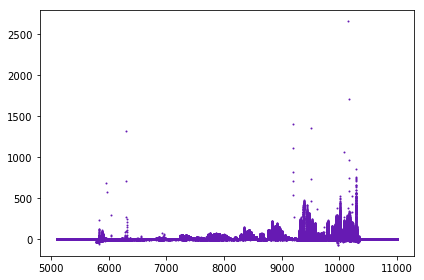

In [435]:
x = wavelength_spec1.data
y = total_flux_residuals_sky_fiber.data

plt.scatter(x,y,s=1,c =[0.4,0.1,0.7])
plt.tight_layout()
plt.show()

In [440]:
total_residual_median_along_fibers = np.median(total_flux_residuals_sky_fiber.data, axis=1)

In [402]:
np.min(residual_median_along_fibers)

0.0

In [403]:
np.max(residual_median_along_fibers)

0.33738804

In [442]:
stats.median_absolute_deviation(total_flux_residuals_sky_fiber.data)

0.91774154

Comparison between estimated average sky signal and total flux from 47 Sky fibers.

0.6744907594765952

#### Sky Flux of SKY Fibers subtracted by the average sky signal
Subtract Average Total Flux of Sky Fibers from Sky Flux of each SKY Fibers

In [407]:
sky_residuals_sky_fiber = np.ma.array(sky_spec1.data - repeated47_average_sky_flux1, mask = sky_spec1.mask)

In [408]:
sky_residuals_sky_fiber.shape

(47, 4128)

In [445]:
sky_residual_median_along_fiber = np.median(sky_residuals_sky_fiber.data)

In [446]:
np.min(sky_residual_median_along_fiber)

0.0

In [447]:
np.max(sky_residual_median_along_fiber)

0.0

In [438]:
stats.median_absolute_deviation(sky_residuals_sky_fiber.data, axis =1)

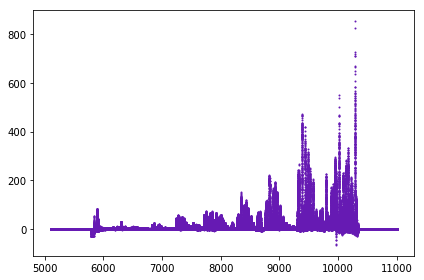

In [439]:
x = wavelength_spec1.data
y = sky_residuals_sky_fiber.data

plt.scatter(x,y,s=1,c =[0.4,0.1,0.7])
plt.tight_layout()
plt.show()

#### Object Flux by subtraction for all non-SKY Fibers
Subtract Average Total Flux of Sky Fibers from Total Flux of non-SKY Fibers

In [314]:
calculated_flux_spec1 =np.ma.array(total_flux_non_sky_spec1.data - repeated_average_sky_flux1, mask = total_flux_non_sky_spec1.mask)

In [315]:
type(calculated_flux_spec1)

numpy.ma.core.MaskedArray

In [316]:
calculated_flux_spec1.shape

(453, 4128)

Comparison between calculated flux and original flux from Non-SKY Fiber data

In [317]:
difference_flux_spec1 = calculated_flux_spec1.data - flux_non_sky_spec1.data

In [388]:
#abs(difference_flux_spec1)/ flux_non_sky_spec1.data

In [319]:
type(difference_flux_spec1)

numpy.ndarray

In [328]:
difference_flux_spec1.mean(axis=0).mean()

3.9319134

In [329]:
flux_non_sky_spec1.data.max()

5059.031

In [330]:
flux_non_sky_spec1.data.min()

-132.85898

### Exposure[0], Spectrograph 2, Fiber 501-1000

Locate and download the file of a single science exposure for spectrogtaph 2. The exposure file to return is set to 'spCFrame'.

In [118]:
exp0_spec2_path = combined_plan.get_exposure_name(sequence_number=0,band='red',fiber = 501,ftype='spCFrame')

In [119]:
exp0_spec2_path

'/sas/dr12/boss/spectro/redux/v5_7_0/4042/spCFrame-r2-00127588.fits'

In [120]:
exp0_spec2_file = mirror.get(exp0_spec2_path)

In [121]:
exp0_spec2_file

'/scratch/kunjias/sdss/sas/dr12/boss/spectro/redux/v5_7_0/4042/spCFrame-r2-00127588.fits'

#### Frame file of exposure[0] of spectrograph 2

Frame file containing single exposure 0 of spectrograph 2 (half plate).

In [122]:
expo0_spec2_frame = plate.FrameFile(exp0_spec2_file, index=2, calibrated = True)

In [123]:
# expo0_spec2_frame
print("plate_number:",expo0_spec2_frame.plate,
'camera:',expo0_spec2_frame.camera,
'exposure_id:',expo0_spec2_frame.exposure_id)
# expo0_spec2_frame.header

plate_number: 4042 camera: r2 exposure_id: 127588


#### Get valid data for the 50 sky fibers in Spectrograph 2.

In [126]:
spec2_sky = expo0_spec2_frame.get_valid_data(fibers = sky_fibers2, pixel_quality_mask=None, include_wdisp=False, include_sky=True, use_ivar=True, use_loglam=False)

In [127]:
# spec2_sky

In [128]:
spec2_sky.shape

(50, 4128)

In [129]:
type(spec2_sky)

numpy.ma.core.MaskedArray

Access the wavelength, flux, sky, and ivar fields by creating new masked arrays.

#### Wavelength

In [135]:
wavelength_spec2 = spec2_sky['wavelength']

In [136]:
wavelength_spec2.shape

(50, 4128)

Total number of data points if all are valid.

In [138]:
50 * 4128

206400

Count the number of non-masked elements along rows (fibers).

In [139]:
wavelength_spec2.count(axis=1)

array([4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128,
       4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128,
       4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128,
       4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128, 4128,
       4128, 4128, 4128, 4128, 4128, 4128])

Total number of valid elements in the flux  masked array.

In [140]:
wavelength_spec2.count(axis=1).sum()

206400

#### FLux

In [141]:
flux_spec2 = spec2_sky['flux']

In [142]:
flux_spec2.shape

(50, 4128)

In [143]:
flux_spec2.count(axis=1)

array([2300, 2254, 2296, 2288, 2314, 2294, 2279, 2268, 2291, 2311, 2269,
       2276, 2302, 2232, 2306, 2278, 2242, 2241, 2233, 2268, 2261, 2237,
       2245, 2250, 2240, 2219, 2244, 2278, 2268, 2261, 2272, 2278, 2223,
       2221, 2278, 2271, 2274, 2261, 2230, 2247, 2280, 2296, 2267, 2265,
       2254, 2244, 2221, 2297, 2229, 2248])

In [144]:
flux_spec2.count(axis=1).sum()

113201

#### Sky

In [145]:
sky_spec2 = spec2_sky['sky']

In [146]:
sky_spec2.count(axis=1)

array([2300, 2254, 2296, 2288, 2314, 2294, 2279, 2268, 2291, 2311, 2269,
       2276, 2302, 2232, 2306, 2278, 2242, 2241, 2233, 2268, 2261, 2237,
       2245, 2250, 2240, 2219, 2244, 2278, 2268, 2261, 2272, 2278, 2223,
       2221, 2278, 2271, 2274, 2261, 2230, 2247, 2280, 2296, 2267, 2265,
       2254, 2244, 2221, 2297, 2229, 2248])

In [147]:
sky_spec2.count(axis=1).sum()

113201

#### Sky + Flux

In [172]:
total_flux_spec2 = np.ma.array(flux_spec2.data + sky_spec2.data, mask=list(map(and_,flux_spec2.mask, sky_spec2.mask)))

In [149]:
total_flux_spec2.shape

(50, 4128)

In [150]:
total_flux_spec2.count(axis=1)

array([2300, 2254, 2296, 2288, 2314, 2294, 2279, 2268, 2291, 2311, 2269,
       2276, 2302, 2232, 2306, 2278, 2242, 2241, 2233, 2268, 2261, 2237,
       2245, 2250, 2240, 2219, 2244, 2278, 2268, 2261, 2272, 2278, 2223,
       2221, 2278, 2271, 2274, 2261, 2230, 2247, 2280, 2296, 2267, 2265,
       2254, 2244, 2221, 2297, 2229, 2248])

Check the total number of valid data in total_flux.

In [151]:
len(total_flux_spec2.compressed())

113201

#### Inverse Variance

Inverse Variance is used as weights to computed the weighted average of total flux for sky fibers.

In [152]:
ivar_spec2 = spec2_sky['ivar']

In [153]:
type(ivar_spec2)

numpy.ma.core.MaskedArray

In [154]:
ivar_spec2.shape

(50, 4128)

Check number of valid data in the inverse variance masked array.

In [155]:
ivar_spec2.count(axis=1).sum()

113201

Fill in the invalid inverse variance data with value 0.

In [156]:
weights_by_ivar2 = ma.filled(ivar_spec2, fill_value=0)

In [157]:
type(weights_by_ivar2)

numpy.ndarray

In [158]:
weights_by_ivar2.shape

(50, 4128)

A plot for the total flux among the 50 sky fibers in spectrograph 2.

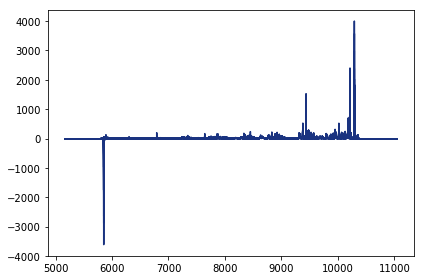

In [171]:
x = wavelength_spec2.data
y = total_flux_spec2.data
plt.plot(x,y,c=[0.1,0.2,0.5])
plt.tight_layout()
plt.show()

#### Simple Average
Average of total_flux among 50 sky fibers without no weights.

In [159]:
simple_average2 = ma.average(total_flux_spec2, axis=0, returned=False)

In [160]:
type(simple_average2)

numpy.ma.core.MaskedArray

In [161]:
simple_average_flux2 = simple_average2.data

Wavelegnth from the first sky fiber (fiber no.14) is taken as the standard wavelength scale to plot the total_flux here.

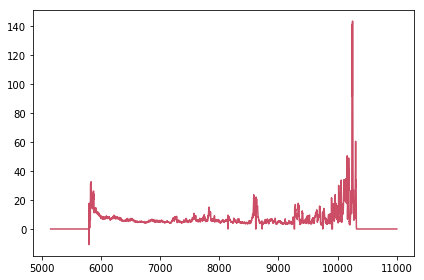

In [162]:
x = wavelength_fiber14
y = simple_average_flux2
plt.plot(x,y,c =[0.8,0.3,0.4])
plt.tight_layout()
plt.show()

#### Weighted Average
Average of total_flux of 50 sky fibers in spectrograph 2 weighted by inverse variance.

In [271]:
weighted_average_spec2 = ma.average(total_flux_spec2,axis=0, weights = weights_by_ivar2, returned= False)

In [272]:
type(weighted_average_spec2)

numpy.ma.core.MaskedArray

In [273]:
average_sky_flux2 = weighted_average_spec2.data

Wavelegnth from the first sky fiber (fiber no.14) is taken as the standard wavelength scale to plot the total_flux here.

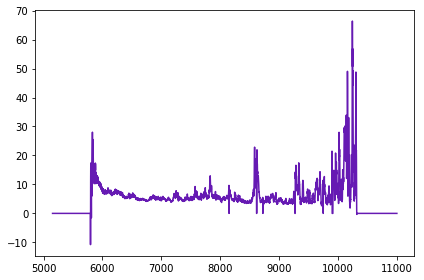

In [274]:
x = wavelength_fiber14
y = average_sky_flux2
plt.plot(x,y,c =[0.4,0.1,0.7])
plt.tight_layout()
plt.show()